In [ ]:
  %cd /content/

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/MEDAI_DEC/archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_

In [ ]:
!pip install torchview

In [ ]:
%cd /content

/content


In [ ]:
cfg_path= "/content/lgg-mri-segmentation/kaggle_3m"

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchsummary import summary
from torchview import draw_graph
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, matthews_corrcoef
from skimage import io, transform, color
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

import random
from collections import defaultdict
import os
import shutil
import copy
from typing import Dict, List, Tuple
import graphviz
import argparse
from torch.utils.tensorboard import SummaryWriter

# /content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = (16 if torch.cuda.device_count() < 2
        else (16 * torch.cuda.device_count()))
seed =768
NUM_WORKERS = os.cpu_count()
LR = 1e-3
PATIENCE= 5
EPOCHS=50
NUM_DEVICES = torch.cuda.device_count()



In [ ]:
NUM_WORKERS

2

In [ ]:

NUM_DEVICES

1

In [ ]:
# Fetching files from the directory
file_list= glob.glob(cfg_path+"/*/*.tif", recursive= True)

In [ ]:

len(file_list)

7858

In [ ]:
file_list[:5]

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_27_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_4.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_30.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_25_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_26_mask.tif']

In [ ]:
# ID sorting for each scan

fl_copy= file_list

In [ ]:
def get_sample_numbers(image_paths):
  sample_numbers= []
  is_mask= []
  for f in image_paths:
    path_list= f.split('/')[-2:][1].split('_')
    print(path_list)

    if 'mask.tif' in path_list:
      sample_numbers.append(int(path_list[-2]))
      is_mask.append(1)
      print(is_mask)
      print(sample_numbers)
    else:
      sample_numbers.append(int(path_list[-1].replace('.tif', '')))
      is_mask.append(0)

  return sample_numbers, is_mask

def get_sample_patient_id(image_paths):
  return [(id_.split('/')[-2:][0]) for id_ in image_paths]



In [ ]:

get_sample_numbers(file_list)

['TCGA', 'HT', '7616', '19940813', '27', 'mask.tif']
[1]
[27]
['TCGA', 'HT', '7616', '19940813', '4.tif']
['TCGA', 'HT', '7616', '19940813', '30.tif']
['TCGA', 'HT', '7616', '19940813', '25', 'mask.tif']
[1, 0, 0, 1]
[27, 4, 30, 25]
['TCGA', 'HT', '7616', '19940813', '26', 'mask.tif']
[1, 0, 0, 1, 1]
[27, 4, 30, 25, 26]
['TCGA', 'HT', '7616', '19940813', '13.tif']
['TCGA', 'HT', '7616', '19940813', '11', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1]
[27, 4, 30, 25, 26, 13, 11]
['TCGA', 'HT', '7616', '19940813', '24', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1, 1]
[27, 4, 30, 25, 26, 13, 11, 24]
['TCGA', 'HT', '7616', '19940813', '27.tif']
['TCGA', 'HT', '7616', '19940813', '12.tif']
['TCGA', 'HT', '7616', '19940813', '11.tif']
['TCGA', 'HT', '7616', '19940813', '12', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1]
[27, 4, 30, 25, 26, 13, 11, 24, 27, 12, 11, 12]
['TCGA', 'HT', '7616', '19940813', '5', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]
[27, 4, 30, 25, 26, 13, 11, 24, 27, 12, 11, 12, 5]
['TC

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[27, 4, 30, 25, 26, 13, 11, 24, 27, 12, 11, 12, 5, 23, 2, 7, 22, 1, 19, 9, 26, 16, 24, 14, 8, 29, 18, 4, 10, 20, 7, 2, 6, 6, 9, 22, 18, 20, 21, 14, 23, 8, 28, 10, 5, 3, 29, 28, 17, 16, 21, 13, 15, 17, 30, 19, 3, 25, 1, 15, 35, 7, 30, 29, 9, 22, 10, 8, 25, 30, 34, 1, 15, 16, 24, 4, 11, 34, 35, 21, 2, 4, 26, 27, 12, 18, 6, 21, 33, 24, 13, 7, 5, 18, 19, 5, 28, 22, 17, 32, 25, 14, 33, 16, 17, 26, 32, 20, 6, 31, 29, 1, 8, 15, 9, 28, 23, 10, 14, 31, 11, 12, 19, 27, 20, 3, 23, 2, 3, 13, 5, 18, 18, 2, 16, 19, 9, 17, 7, 3, 5, 15, 2, 11, 1, 8, 14, 17, 12, 10, 4, 6, 13, 3, 14, 16, 15, 9, 13, 6, 10, 4, 20, 11, 12, 1, 7, 20, 8, 19, 9, 7, 11, 12, 3, 3, 19, 10, 14, 2, 4, 10, 15, 2, 1, 18, 6, 7, 14, 19, 8, 1, 18, 8, 5, 13, 11, 17, 16, 16, 9, 15, 17, 4, 20, 5, 12, 6, 20, 13, 14, 23, 20, 2, 18, 12, 4, 9, 6, 18, 7, 1, 13, 16, 17, 11, 8, 19, 5, 7, 26, 21, 4, 17, 11, 14, 25, 3, 8, 15, 22, 24, 27, 6, 15, 22, 20, 21, 12, 25, 13, 10, 3, 26, 24, 27, 19, 1, 23, 9, 16, 5, 2, 10, 58, 55, 6, 17, 5, 26, 4, 9, 39, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['TCGA', 'HT', '7605', '19950916', '23', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([27,
  4,
  30,
  25,
  26,
  13,
  11,
  24,
  27,
  12,
  11,
  12,
  5,
  23,
  2,
  7,
  22,
  1,
  19,
  9,
  26,
  16,
  24,
  14,
  8,
  29,
  18,
  4,
  10,
  20,
  7,
  2,
  6,
  6,
  9,
  22,
  18,
  20,
  21,
  14,
  23,
  8,
  28,
  10,
  5,
  3,
  29,
  28,
  17,
  16,
  21,
  13,
  15,
  17,
  30,
  19,
  3,
  25,
  1,
  15,
  35,
  7,
  30,
  29,
  9,
  22,
  10,
  8,
  25,
  30,
  34,
  1,
  15,
  16,
  24,
  4,
  11,
  34,
  35,
  21,
  2,
  4,
  26,
  27,
  12,
  18,
  6,
  21,
  33,
  24,
  13,
  7,
  5,
  18,
  19,
  5,
  28,
  22,
  17,
  32,
  25,
  14,
  33,
  16,
  17,
  26,
  32,
  20,
  6,
  31,
  29,
  1,
  8,
  15,
  9,
  28,
  23,
  10,
  14,
  31,
  11,
  12,
  19,
  27,
  20,
  3,
  23,
  2,
  3,
  13,
  5,
  18,
  18,
  2,
  16,
  19,
  9,
  17,
  7,
  3,
  5,
  15,
  2,
  11,
  1,
  8,
  14,
  17,
  12,
  10,
  4,
  6,
  13,
  3,
  14,
  16,
  15,
  9,
  13,
  6,
  10,
  4,
  20,
  11,
  12,
  1,
  7,
  20,
  8,
  19,
  9,
  7,
  11,
  12,
  3,
  3,
  

In [ ]:
get_sample_patient_id(file_list)

['TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_7616_19940813',
 'TCGA_HT_76

In [ ]:

def build_df(image_paths):
  sample_numbers, mask_label= get_sample_numbers(image_paths)
  sample_df= pd.DataFrame({
      'id': sample_numbers ,
      'patient': get_sample_patient_id(image_paths),
      'image_path': image_paths,
      'is_mask': mask_label,

  })
  return sample_df

In [ ]:
dataset_df=(build_df(file_list).sort_values(by= ['id', 'patient', 'image_path']).reset_index(drop= True))

['TCGA', 'HT', '7616', '19940813', '27', 'mask.tif']
[1]
[27]
['TCGA', 'HT', '7616', '19940813', '4.tif']
['TCGA', 'HT', '7616', '19940813', '30.tif']
['TCGA', 'HT', '7616', '19940813', '25', 'mask.tif']
[1, 0, 0, 1]
[27, 4, 30, 25]
['TCGA', 'HT', '7616', '19940813', '26', 'mask.tif']
[1, 0, 0, 1, 1]
[27, 4, 30, 25, 26]
['TCGA', 'HT', '7616', '19940813', '13.tif']
['TCGA', 'HT', '7616', '19940813', '11', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1]
[27, 4, 30, 25, 26, 13, 11]
['TCGA', 'HT', '7616', '19940813', '24', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1, 1]
[27, 4, 30, 25, 26, 13, 11, 24]
['TCGA', 'HT', '7616', '19940813', '27.tif']
['TCGA', 'HT', '7616', '19940813', '12.tif']
['TCGA', 'HT', '7616', '19940813', '11.tif']
['TCGA', 'HT', '7616', '19940813', '12', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1]
[27, 4, 30, 25, 26, 13, 11, 24, 27, 12, 11, 12]
['TCGA', 'HT', '7616', '19940813', '5', 'mask.tif']
[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]
[27, 4, 30, 25, 26, 13, 11, 24, 27, 12, 11, 12, 5]
['TC

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[27, 4, 30, 25, 26, 13, 11, 24, 27, 12, 11, 12, 5, 23, 2, 7, 22, 1, 19, 9, 26, 16, 24, 14, 8, 29, 18, 4, 10, 20, 7, 2, 6, 6, 9, 22, 18, 20, 21, 14, 23, 8, 28, 10, 5, 3, 29, 28, 17, 16, 21, 13, 15, 17, 30, 19, 3, 25, 1, 15, 35, 7, 30, 29, 9, 22, 10, 8, 25, 30, 34, 1, 15, 16, 24, 4, 11, 34, 35, 21, 2, 4, 26, 27, 12, 18, 6, 21, 33, 24, 13, 7, 5, 18, 19, 5, 28, 22, 17, 32, 25, 14, 33, 16, 17, 26, 32, 20, 6, 31, 29, 1, 8, 15, 9, 28, 23, 10, 14, 31, 11, 12, 19, 27, 20, 3, 23, 2, 3, 13, 5, 18, 18, 2, 16, 19, 9, 17, 7, 3, 5, 15, 2, 11, 1, 8, 14, 17, 12, 10, 4, 6, 13, 3, 14, 16, 15, 9, 13, 6, 10, 4, 20, 11, 12, 1, 7, 20, 8, 19, 9, 7, 11, 12, 3, 3, 19, 10, 14, 2, 4, 10, 15, 2, 1, 18, 6, 7, 14, 19, 8, 1, 18, 8, 5, 13, 11, 17, 16, 16, 9, 15, 17, 4, 20, 5, 12, 6, 20, 13, 14, 23, 20, 2, 18, 12, 4, 9, 6, 18, 7, 1, 13, 16, 17, 11, 8, 19, 5, 7, 26, 21, 4, 17, 11, 14, 25, 3, 8, 15, 22, 24, 27, 6, 15, 22, 20, 21, 12, 25, 13, 10, 3, 26, 24, 27, 19, 1, 23, 9, 16, 5, 2, 10, 58, 55, 6, 17, 5, 26, 4, 9, 39, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
dataset_df.head()

id                patient  \
0   1  TCGA_CS_4941_19960909   
1   1  TCGA_CS_4941_19960909   
2   1  TCGA_CS_4942_19970222   
3   1  TCGA_CS_4942_19970222   
4   1  TCGA_CS_4943_20000902   

                                          image_path  is_mask  
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...        0  
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...        1  
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...        0  
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...        1  
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...        0

In [ ]:
#Group Samples by mask status

grouped_df= dataset_df.groupby(by= 'is_mask')
image_df = grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True)
mask_df = grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)

In [ ]:
mask_df= mask_df.rename({'image_path' : 'mask_path'}, axis=1)

In [ ]:
mask_df

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4942_19970222   
2      1  TCGA_CS_4943_20000902   
3      1  TCGA_CS_4944_20010208   
4      1  TCGA_CS_5393_19990606   
...   ..                    ...   
3924  86  TCGA_HT_A61B_19991127   
3925  87  TCGA_HT_A61A_20000127   
3926  87  TCGA_HT_A61B_19991127   
3927  88  TCGA_HT_A61A_20000127   
3928  88  TCGA_HT_A61B_19991127   

                                              mask_path  
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
...                                                 ...  
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  

[3929 rows x 3 columns]

In [ ]:
def _load(image_path, as_tensor= True):
  image=Image.open(image_path)
  image= np.array(image).astype(np.float32) / 255.
  return image

def generate_label(mask_path, load_fn):
  mask= load_fn(mask_path)
  if mask.max() > 0:
    return 1
  return 0

In [ ]:
ds= image_df.merge(mask_df, on=['id', 'patient'], how='left')



In [ ]:
ds

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4942_19970222   
2      1  TCGA_CS_4943_20000902   
3      1  TCGA_CS_4944_20010208   
4      1  TCGA_CS_5393_19990606   
...   ..                    ...   
3924  86  TCGA_HT_A61B_19991127   
3925  87  TCGA_HT_A61A_20000127   
3926  87  TCGA_HT_A61B_19991127   
3927  88  TCGA_HT_A61A_20000127   
3928  88  TCGA_HT_A61B_19991127   

                                             image_path  \
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
...                                                 ...   
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   

                                              mask_path  
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
...                                                 ...  
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  

[3929 rows x 4 columns]

In [ ]:
ds['diagnosis'] = [generate_label(_, _load) for _ in tqdm(ds['mask_path'])]

100%|██████████| 3929/3929 [00:02<00:00, 1590.39it/s]


In [ ]:
ds

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4942_19970222   
2      1  TCGA_CS_4943_20000902   
3      1  TCGA_CS_4944_20010208   
4      1  TCGA_CS_5393_19990606   
...   ..                    ...   
3924  86  TCGA_HT_A61B_19991127   
3925  87  TCGA_HT_A61A_20000127   
3926  87  TCGA_HT_A61B_19991127   
3927  88  TCGA_HT_A61A_20000127   
3928  88  TCGA_HT_A61B_19991127   

                                             image_path  \
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
...                                                 ...   
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   

                                              mask_path  diagnosis  
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...          0  
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...          0  
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...          0  
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...          0  
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...          0  
...                                                 ...        ...  
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0  
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0  
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0  
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0  
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0  

[3929 rows x 5 columns]

<ipython-input-28-2968cc3ca7e2>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot= sns.barplot(
<ipython-input-28-2968cc3ca7e2>:10: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bar_plot= sns.barplot(


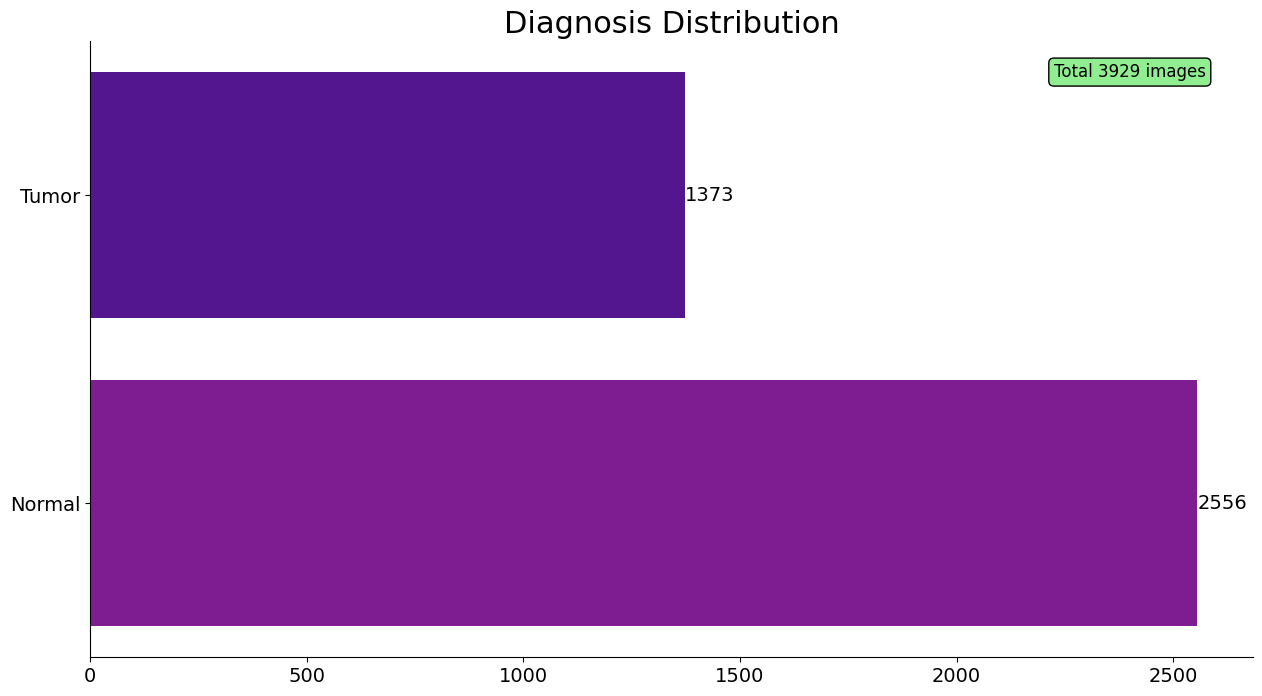

In [ ]:
# To View Diagnosis Distribution

fig= plt.figure(figsize= (15,8))

plt.title("Diagnosis Distribution", fontsize= 22)

diagnosis_distribution =ds['diagnosis'].value_counts().sort_values()
diagnosis_map = {0 : 'Normal', 1 : 'Tumor'}

bar_plot= sns.barplot(
    x= diagnosis_distribution.values,
    y= [diagnosis_map[_] for _ in diagnosis_distribution.keys()],
    palette= sns.color_palette("plasma"),
    orient= 'h'
)

for container in bar_plot.containers:
  bar_plot.bar_label(container, fmt= '%.0f', fontsize= 14)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)

text_params= {
    'x' : 2400,
    'y' : -0.4,
    's' : f"Total {len(ds)} images",
    'size' : 12,
    'color' : "Black",
    'ha'    : "center",
    'va'    : "center",
    'bbox'  : dict(boxstyle= "round", fc= ("lightgreen"), ec= ("black"))

}
plt.text(**text_params)

sns.despine()




diagnosi_map= [_ for _ in diagnosis_distribution.keys()]


In [ ]:
def view_sample(image, mask, color_map= 'rgb', fig_size= (16,8), title_size= 18):
  plt.figure(figsize= fig_size);
  plt.tight_layout();
  plt.subplots_adjust(top= 0.95);

  plt.subplot(1,3, 1);
  plt.title("MRI", fontsize= title_size);
  if color_map == "rgb":
    plt.imshow(image);
  else:
    plt.imshow(image, cmap= color_map);

  plt.subplot(1, 3, 2);
  plt.title("Mask", fontsize= title_size);
  plt.imshow(mask, cmap= "gray");

  plt.subplot(1, 3, 3);
  plt.title("MRI + Mask", fontsize= title_size);

  if color_map == "rgb":
    plt.imshow(image)
  else:
    plt.imshow(image, cmap= color_map)

  plt.imshow(mask, cmap="gray", alpha= 0.5);

  return








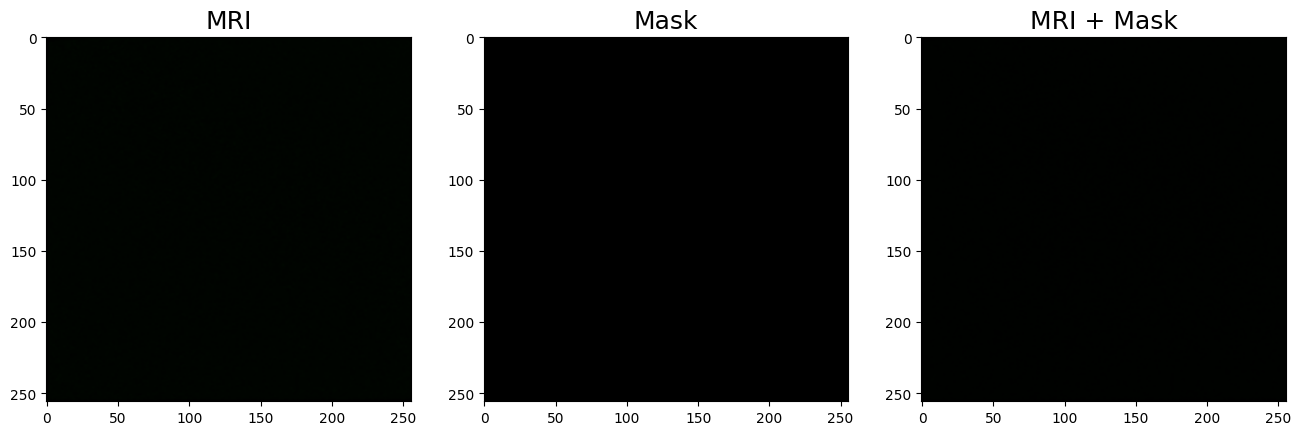

In [ ]:
rd_num= random.sample(ds.index.to_list(), 1)[0]
sample_image, sample_mask= _load(ds.image_path[rd_num]),  _load(ds.mask_path[rd_num])
view_sample(sample_image, sample_mask, color_map= 'mako')

In [ ]:
def view_multiple_sample(df, sample_loader, count= 10, color_map= "rgb", fig_size= (14, 10) ,title_size= 18):

  rd_num= random.sample(df.index.to_list(), count)
  plt.figure(figsize= fig_size);
  plt.tight_layout();
  plt.subplots_adjust(top= 0.95)

  for x, y in enumerate(rd_num):
    image, mask= (sample_loader(df.image_path[y]),sample_loader(df.mask_path[y]))

    idx= 3 * (x+1)
    plt.subplot(count+1, 3, idx+1);
    plt.title("MRI", fontsize= title_size);
    if color_map== "rgb":
      plt.imshow(image);
    else:
      plt.imshow(image, cmap= color_map);

    plt.subplot(count+1, 3, idx+2);
    plt.title("Mask", fontsize= title_size);
    plt.imshow(mask, cmap= "gray")

    plt.subplot(count+1, 3, idx+3)
    plt.title("MRI + MASK", fontsize= title_size)
    if color_map== "rgb":
      plt.imshow(image)
    else:
      plt.imshow(image, cmap= color_map)
    plt.imshow(mask, cmap ="gray", alpha= 0.5)

  return




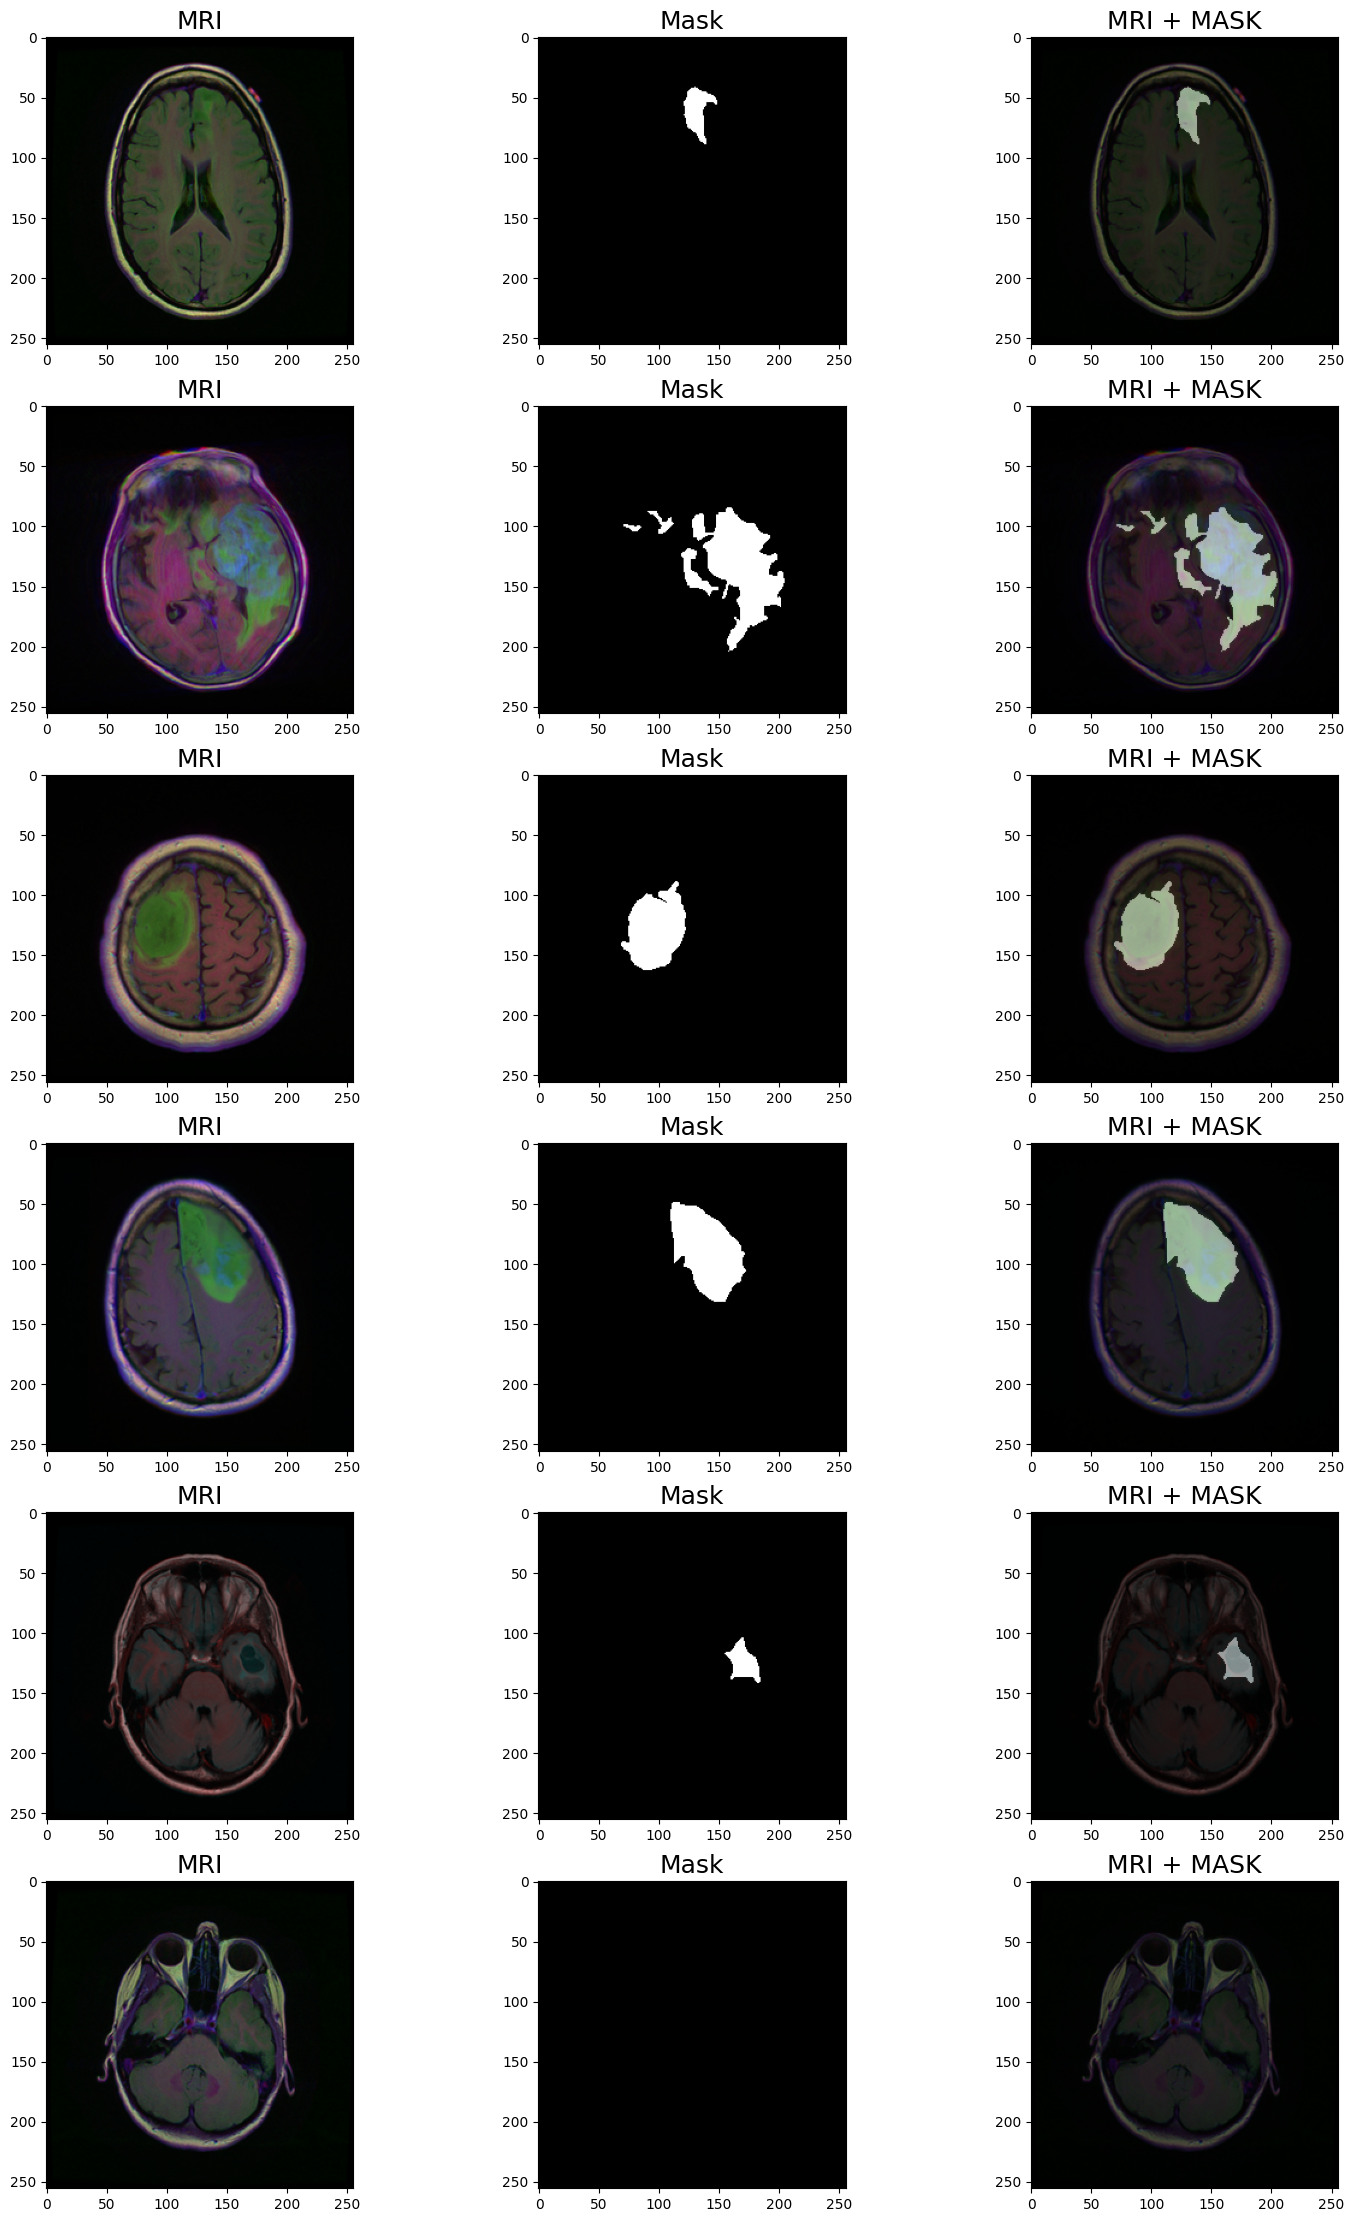

In [ ]:
view_multiple_sample(ds, _load, count=6, color_map = "mako", fig_size= (18, 30)  )


In [ ]:
#Augment train data
train_transforms= A.Compose([
    A.Resize(224, 224, p=1.0),
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

# Reshape Inference data
inference_transforms= A.Compose([
    A.Resize(224, 224, p=1.0),
    ToTensorV2(),
])


In [ ]:
class MRISegmentationDataset(Dataset):
  def __init__(self, df:pd.DataFrame, transform= None) -> None:
    super().__init__()

    self.mri_paths= df['image_path'].to_list()
    self.mask_paths= df['mask_path'].to_list()

    self.transform= transform

  def load_sample(self, index:str) -> Image.Image:
    image_path= self.mri_paths[index]
    mask_path= self.mask_paths[index]

    image= Image.open(image_path)
    mask= Image.open(mask_path)

    image= np.array(image).astype(np.float32) /255.
    mask= np.array(mask).astype(np.float32) /255.


    return image, mask

  def __len__(self) -> int:
    return self.mri_paths.__len__()

  def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor]:
    image,mask = self.load_sample(index)

    if self.transform:
      transformed= self.transform(image= image, mask= mask)
      return transformed['image'], transformed['mask'].unsqueeze_(0)
    else:
      transformed= ToTensorV2()(image= image, mask=mask)
      return transformed['image'], transformed['mask'].unsqueeze_(0)








In [ ]:
class BCEDiceLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input, target):
    bce = F.binary_cross_entropy_with_logits(input, target)
    smooth = 1e-5
    input = torch.sigmoid(input)
    # input = torch.tanh(input)
    num = target.size(0)
    input = input.view(num, -1)
    target = target.view(num, -1)
    intersection = (input * target)
    dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return 0.5 * bce + dice


class GliomaNetLoss(nn.Module):
  def __init__(self):
    super(GliomaNetLoss, self).__init__()
    self.loss = BCEDiceLoss()

  def forward(self, d0, d1, d2, d3, d4, d5, labels_v):
    loss0 = self.loss(d0, labels_v)
    loss1 = self.loss(d1, labels_v)
    loss2 = self.loss(d2, labels_v)
    loss3 = self.loss(d3, labels_v)
    loss4 = self.loss(d4, labels_v)
    loss5 = self.loss(d5, labels_v)
    # loss6 = self.loss(d6, labels_v)
    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5
    print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f\n" % (
        loss0.data, loss1.data, loss2.data, loss3.data, loss4.data, loss5.data))
    return loss0, loss

In [ ]:
def weight_init(m):
    if isinstance(m, (nn.Conv2d,)):
        # torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        # torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, mean=0.0)

        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

    # for fusion layer
    if isinstance(m, (nn.ConvTranspose2d,)):
        # torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        # torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)

        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, std=0.1)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


class CoFusion(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(CoFusion, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, 64, kernel_size=3,
                               stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3,
                               stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, out_ch, kernel_size=3,
                               stride=1, padding=1)
        self.relu = nn.ReLU()

        self.norm_layer1 = nn.GroupNorm(4, 64)
        self.norm_layer2 = nn.GroupNorm(4, 64)

    def forward(self, x):
        # fusecat = torch.cat(x, dim=1)
        attn = self.relu(self.norm_layer1(self.conv1(x)))
        attn = self.relu(self.norm_layer2(self.conv2(attn)))
        attn = F.softmax(self.conv3(attn), dim=1)

        # return ((fusecat * attn).sum(1)).unsqueeze(1)
        return ((x * attn).sum(1)).unsqueeze(1)

class _DenseLayer(nn.Sequential):
    def __init__(self, input_features, out_features):
        super(_DenseLayer, self).__init__()

        # self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(input_features, out_features,
                                           kernel_size=3, stride=1, padding=2, bias=True)),
        self.add_module('norm1', nn.BatchNorm2d(out_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(out_features, out_features,
                                           kernel_size=3, stride=1, bias=True)),
        self.add_module('norm2', nn.BatchNorm2d(out_features))

    def forward(self, x):
        x1, x2 = x

        new_features = super(_DenseLayer, self).forward(F.relu(x1))  # F.relu()
        # if new_features.shape[-1]!=x2.shape[-1]:
        #     new_features =F.interpolate(new_features,size=(x2.shape[2],x2.shape[-1]), mode='bicubic',
        #                                 align_corners=False)
        return 0.5 * (new_features + x2), x2


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, input_features, out_features):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(input_features, out_features)
            self.add_module('denselayer%d' % (i + 1), layer)
            input_features = out_features


class UpConvBlock(nn.Module):
    def __init__(self, in_features, up_scale):
        super(UpConvBlock, self).__init__()
        self.up_factor = 2
        self.constant_features = 16

        layers = self.make_deconv_layers(in_features, up_scale)
        assert layers is not None, layers
        self.features = nn.Sequential(*layers)

    def make_deconv_layers(self, in_features, up_scale):
        layers = []
        all_pads=[0,0,1,3,7]
        for i in range(up_scale):
            kernel_size = 2 ** up_scale
            pad = all_pads[up_scale]  # kernel_size-1
            out_features = self.compute_out_features(i, up_scale)
            layers.append(nn.Conv2d(in_features, out_features, 1))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.ConvTranspose2d(
                out_features, out_features, kernel_size, stride=2, padding=pad))
            in_features = out_features
        return layers

    def compute_out_features(self, idx, up_scale):
        return 1 if idx == up_scale - 1 else self.constant_features

    def forward(self, x):
        return self.features(x)


class SingleConvBlock(nn.Module):
    def __init__(self, in_features, out_features, stride,
                 use_bs=True
                 ):
        super(SingleConvBlock, self).__init__()
        self.use_bn = use_bs
        self.conv = nn.Conv2d(in_features, out_features, 1, stride=stride,
                              bias=True)
        self.bn = nn.BatchNorm2d(out_features)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        return x


class DoubleConvBlock(nn.Module):
    def __init__(self, in_features, mid_features,
                 out_features=None,
                 stride=1,
                 use_act=True):
        super(DoubleConvBlock, self).__init__()

        self.use_act = use_act
        if out_features is None:
            out_features = mid_features
        self.conv1 = nn.Conv2d(in_features, mid_features,
                               3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(mid_features)
        self.conv2 = nn.Conv2d(mid_features, out_features, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_act:
            x = self.relu(x)
        return x


class DexiNed(nn.Module):
    """ Definition of the DXtrem network. """

    def __init__(self):
        super(DexiNed, self).__init__()
        self.block_1 = DoubleConvBlock(3, 32, 64, stride=2,)
        self.block_2 = DoubleConvBlock(64, 128, use_act=False)
        self.dblock_3 = _DenseBlock(2, 128, 256) # [128,256,100,100]
        self.dblock_4 = _DenseBlock(3, 256, 512)
        self.dblock_5 = _DenseBlock(3, 512, 512)
        self.dblock_6 = _DenseBlock(3, 512, 256)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # left skip connections, figure in Journal
        self.side_1 = SingleConvBlock(64, 128, 2)
        self.side_2 = SingleConvBlock(128, 256, 2)
        self.side_3 = SingleConvBlock(256, 512, 2)
        self.side_4 = SingleConvBlock(512, 512, 1)
        self.side_5 = SingleConvBlock(512, 256, 1) # Sory I forget to comment this line :(

        # right skip connections, figure in Journal paper
        self.pre_dense_2 = SingleConvBlock(128, 256, 2)
        self.pre_dense_3 = SingleConvBlock(128, 256, 1)
        self.pre_dense_4 = SingleConvBlock(256, 512, 1)
        self.pre_dense_5 = SingleConvBlock(512, 512, 1)
        self.pre_dense_6 = SingleConvBlock(512, 256, 1)


        self.up_block_1 = UpConvBlock(64, 1)
        self.up_block_2 = UpConvBlock(128, 1)
        self.up_block_3 = UpConvBlock(256, 2)
        self.up_block_4 = UpConvBlock(512, 3)
        self.up_block_5 = UpConvBlock(512, 4)
        self.up_block_6 = UpConvBlock(256, 4)
        self.block_cat = SingleConvBlock(6, 1, stride=1, use_bs=False) # hed fusion method
        # self.block_cat = CoFusion(6,6)# cats fusion method


        self.apply(weight_init)

    def slice(self, tensor, slice_shape):
        t_shape = tensor.shape
        height, width = slice_shape
        if t_shape[-1]!=slice_shape[-1]:
            new_tensor = F.interpolate(
                tensor, size=(height, width), mode='bicubic',align_corners=False)
        else:
            new_tensor=tensor
        # tensor[..., :height, :width]
        return new_tensor

    def forward(self, x):
        assert x.ndim == 4, x.shape

        # Block 1
        block_1 = self.block_1(x)
        block_1_side = self.side_1(block_1)

        # Block 2
        block_2 = self.block_2(block_1)
        block_2_down = self.maxpool(block_2)
        block_2_add = block_2_down + block_1_side
        block_2_side = self.side_2(block_2_add)

        # Block 3
        block_3_pre_dense = self.pre_dense_3(block_2_down)
        block_3, _ = self.dblock_3([block_2_add, block_3_pre_dense])
        block_3_down = self.maxpool(block_3) # [128,256,50,50]
        block_3_add = block_3_down + block_2_side
        block_3_side = self.side_3(block_3_add)

        # Block 4
        block_2_resize_half = self.pre_dense_2(block_2_down)
        block_4_pre_dense = self.pre_dense_4(block_3_down+block_2_resize_half)
        block_4, _ = self.dblock_4([block_3_add, block_4_pre_dense])
        block_4_down = self.maxpool(block_4)
        block_4_add = block_4_down + block_3_side
        block_4_side = self.side_4(block_4_add)

        # Block 5
        block_5_pre_dense = self.pre_dense_5(
            block_4_down) #block_5_pre_dense_512 +block_4_down
        block_5, _ = self.dblock_5([block_4_add, block_5_pre_dense])
        block_5_add = block_5 + block_4_side

        # Block 6
        block_6_pre_dense = self.pre_dense_6(block_5)
        block_6, _ = self.dblock_6([block_5_add, block_6_pre_dense])

        # upsampling blocks
        d0 = self.up_block_1(block_1)
        d1 = self.up_block_2(block_2)
        d2 = self.up_block_3(block_3)
        d3 = self.up_block_4(block_4)
        d4 = self.up_block_5(block_5)
        d5 = self.up_block_6(block_6)
        # results = [out_1, out_2, out_3, out_4, out_5, out_6]

        # # concatenate multiscale outputs
        # block_cat = torch.cat(results, dim=1)  # Bx6xHxW
        # block_cat = self.block_cat(block_cat)  # Bx1xHxW

        # # return results
        # results.append(block_cat)

        return d0, d1, d2, d3, d4, d5


In [ ]:
net = DexiNed().to(DEVICE)

summary(net, input_size=(3, 224, 224), batch_size= 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 112, 112]             896
       BatchNorm2d-2          [1, 32, 112, 112]              64
              ReLU-3          [1, 32, 112, 112]               0
            Conv2d-4          [1, 64, 112, 112]          18,496
       BatchNorm2d-5          [1, 64, 112, 112]             128
              ReLU-6          [1, 64, 112, 112]               0
   DoubleConvBlock-7          [1, 64, 112, 112]               0
            Conv2d-8           [1, 128, 56, 56]           8,320
       BatchNorm2d-9           [1, 128, 56, 56]             256
  SingleConvBlock-10           [1, 128, 56, 56]               0
           Conv2d-11         [1, 128, 112, 112]          73,856
      BatchNorm2d-12         [1, 128, 112, 112]             256
             ReLU-13         [1, 128, 112, 112]               0
           Conv2d-14         [1, 128, 1

In [ ]:
# Splitting the dataset for training
train_split_idx, data_split_idx, _, _= train_test_split(ds.index, ds.diagnosis, test_size= 0.30, stratify= ds.diagnosis, random_state= seed)

In [ ]:
train_df= ds.iloc[train_split_idx].reset_index(drop=True)
data_df= ds.iloc[data_split_idx].reset_index(drop=True)

In [ ]:
print(train_df.shape)
print(data_df.shape)

(2750, 5)
(1179, 5)


In [ ]:
val_split_idx, test_split_idx, _, _ = train_test_split(data_df.index, data_df.diagnosis, test_size= 0.65, stratify = data_df.diagnosis, random_state= seed )

In [ ]:
val_df= data_df.iloc[val_split_idx].reset_index(drop= True)
test_df= data_df.iloc[test_split_idx].reset_index(drop= True)

In [ ]:
print(val_df.shape)
print(test_df.shape)

(412, 5)
(767, 5)


In [ ]:
train_size= len(train_df)
test_size= len(test_df)
val_size= len(val_df)
total_size= train_size + test_size + val_size

print("===================================================")
print(f'Training Sample Size:\t\t{train_size}\t({(100 * train_size/total_size):.2f}%)')
print(f'Testing Sample Size:\t\t{test_size}\t({(100 * test_size/total_size):.2f}%)')
print(f'Validation Sample Size:\t\t{val_size}\t({(100 * val_size/total_size):.2f}%)')
print("===================================================")

print(f'Total \t\t\t\t{total_size}\t({(100 * total_size/total_size):.2f}%)')


Training Sample Size:		2750	(69.99%)
Testing Sample Size:		767	(19.52%)
Validation Sample Size:		412	(10.49%)
Total 				3929	(100.00%)


In [ ]:
tra_img_name_list= train_df['image_path'].to_list()
tra_lbl_name_list= train_df['mask_path'].to_list()

In [ ]:
tra_lbl_name_list[0]

'/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_12_mask.tif'

In [ ]:
kwargs= {
    'name' : 'GliomaNet',
    'epochs' : 200,
    'batch_size': 30,
    'input_size': 224,
    'data_folder_name': 'train_data',
    'optimizer': 'Adam',
    'lr': 0.001,
    'nesterov': False,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'scheduler': 'CosineAnnealingLR',
    'min_lr': 1e-7,
    'factor': 0.1,
    'patience': 3,
    'milestones': '1,2',
    'gamma' : 2/3,
    'early_stopping' : 1,
    'num_workers':4
}

In [ ]:
# glioma_dataloader = MRISegmentationDataset(img_name_list=tra_img_name_list, lbl_name_list=tra_lbl_name_list,transform= train_transforms)
# my_glioma_dataloader = DataLoader(glioma_dataloader, batch_size=4, shuffle=True , num_workers=kwargs['num_workers'])

In [ ]:
#Building Datasets
train_ds= MRISegmentationDataset(train_df, transform= train_transforms)

val_ds= MRISegmentationDataset(val_df, transform= inference_transforms)

test_ds= MRISegmentationDataset(test_df, transform= inference_transforms)


In [ ]:
image,mask =  train_ds.__getitem__(0)
# sample= {'imidx': imidx, 'image': image, 'label': label}
print( image.shape,mask.shape)

torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


In [ ]:
class Model_Train():
  def __init__(self ,tra_img_name_list, tra_lbl_name_list, **kwargs):
      self.model_loss = GliomaNetLoss()
      self.model_name = kwargs['name']
      self.epoch_num = kwargs['epochs']
      self.save_frq = 3500  # save the model every 3500 iterations
      self.batch_size_train = kwargs['batch_size']
      self.epoch = 0
      self.model_dir= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/'

      self.root_dir = "/content/"
      self.log_dir = os.path.join(self.root_dir, "logs/my_board/" + os.sep)
      self.pthFile_name = "NONE"
      self.writer = SummaryWriter(self.log_dir)

      # ------- 2. set the directory of training dataset --------
      # data_dir = os.path.join(self.root_dir, config['data_folder_name'] + os.sep)
      # tra_image_dir = os.path.join("images" + os.sep)
      # tra_label_dir = os.path.join("labels" + os.sep)
      # image_ext = ".jpg"
      # label_ext = ".bmp"
      # self.model_dir = os.path.join(self.root_dir, config['data_folder_name'], self.model_name + os.sep)
      # os.makedirs(self.model_dir, exist_ok=True)
      # tra_img_name_list = glob.glob(data_dir + tra_image_dir + "*" + image_ext)

      # tra_lbl_name_list = []
      # for img_path in tra_img_name_list:
      #     img_name = img_path.split(os.sep)[-1]
      #     aaa = img_name.split(".")
      #     bbb = aaa[0:-1]
      #     imidx = bbb[0]
      #     for i in range(1, len(bbb)):
      #         imidx = imidx + "." + bbb[i]
      #     tra_lbl_name_list.append(data_dir + tra_label_dir + imidx + label_ext)

      print("---")
      print("train images: ", len(tra_img_name_list))
      print("train labels: ", len(tra_lbl_name_list))
      print("---")
      self.train_num = len(tra_img_name_list)
      # glioma_dataloader = Glioma_dataloader(img_name_list=tra_img_name_list, lbl_name_list=tra_lbl_name_list,
      #                                       transform= train_transforms)

                                      # transform=transforms.Compose([RescaleT(kwargs['input_size']), ToTensorLab(flag=0)]), )
      self.glioma_dataloader = DataLoader(train_ds, batch_size=self.batch_size_train, shuffle=True , num_workers=kwargs['num_workers'])
      # self.model = Glioma_U2NET(kwargs['input_channels'], kwargs['num_classes'], kwargs['F_int'])
      self.model= DexiNed().cuda()

      params = filter(lambda p: p.requires_grad, self.model.parameters())
      if kwargs['optimizer'] == 'Adam':
        self.optimizer = optim.Adam(params, lr=kwargs['lr'], betas=(0.9, 0.999), eps=1e-08,weight_decay=0, ) #weight_decay=config['weight_decay'])
      elif kwargs['optimizer'] == 'SGD':
        self.optimizer = optim.SGD(params, lr=kwargs['lr'], momentum=kwargs['momentum'], nesterov=kwargs['nesterov'],weight_decay=kwargs['weight_decay'])
      else:
        raise NotImplementedError

      if kwargs['scheduler'] == 'CosineAnnealingLR':
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=kwargs['epochs'], eta_min=kwargs['min_lr'])
      elif kwargs['scheduler'] == 'ReduceLROnPlateau':
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=kwargs['factor'], patience=kwargs['patience'],
                                                      verbose=1, min_lr=kwargs['min_lr'])
      elif kwargs['scheduler'] == 'MultiStepLR':
        self.scheduler = lr_scheduler.MultiStepLR(self.optimizer,
                                                milestones=[int(e) for e in kwargs['milestones'].split(',')],
                                                gamma=kwargs['gamma'])
      elif kwargs['scheduler'] == 'ConstantLR':
        self.scheduler = None
      else:
        raise NotImplementedError
  def model_train(self):
    if self.pthFile_name != "NONE":
      checkpoint = torch.load(self.pthFile_name)
      print("Pretrained Model - Started for training")
      if checkpoint["epoch"] > 0:
        self.model.load_state_dict(checkpoint["model_state_dict"])
        epoch = checkpoint["epoch"]
        print(f"=====> epoch:{epoch}")
        if torch.cuda.is_available():
          self.model.cuda()
          # ------- 4. define optimizer --------
        print("---define optimizer on retraining...")
        # self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
      else:
        if torch.cuda.is_available():
            self.model.cuda()
        # ------- 4. define optimizer --------
        print("---define optimizer...")
        #self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )
    else:
      if torch.cuda.is_available():
        self.model.cuda()
      # ------- 4. define optimizer --------
      print("---define optimizer...")
      # self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, )

      # ------- 5. training process --------
    print("---start training...")
    ite_num = 0
    running_loss = 0.0
    running_tar_loss = 0.0
    ite_num4val = 0
    while self.epoch < self.epoch_num:
      self.model.train()
      for i, data in enumerate(self.glioma_dataloader):
        ite_num = ite_num + 1
        ite_num4val = ite_num4val + 1
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        # wrap them in Variable
        if torch.cuda.is_available():
          inputs_v, labels_v = (
          Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(), requires_grad=False),)
        else:
          inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        # y zero the parameter gradients
        self.optimizer.zero_grad()
        # forward + backward + optimize
        # d0, d1, d2, d3, d4, d5, d6 = self.model(inputs_v)
        d0, d1, d2, d3, d4, d5= self.model(inputs_v)
        loss2, loss = self.model_loss(d0, d1, d2, d3, d4, d5, labels_v)
        loss.backward()
        self.optimizer.step()
        # # print statistics
        running_loss += loss.data
        running_tar_loss += loss2.data
        # del temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, loss2, loss
        print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
            self.epoch + 1, self.epoch_num, (i + 1) * self.batch_size_train, self.train_num, ite_num,
            running_loss / ite_num4val,
            running_tar_loss / ite_num4val,))

        self.writer.add_scalar("train loss", running_loss / ite_num4val, self.epoch + 1)
        self.writer.add_scalar("tar loss", running_tar_loss / ite_num4val)

        if ite_num % self.save_frq == 0:
          torch.save({"epoch": self.epoch, "model_state_dict": self.model.state_dict(),
                      "optimizer_state_dict": self.optimizer.state_dict(), },
                      self.model_dir + self.model_name + "_%d_at8_dexnet_bce_itr_%d_train_%3f_tar_%3f.pth" % (
                      self.epoch, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val,), )
          running_loss = 0.0
          running_tar_loss = 0.0
          self.model.train()  # resume train
          ite_num4val = 0

      self.epoch = self.epoch + 1
      self.scheduler.step()

    torch.save(
        {"epoch": self.epoch, "model_state_dict": self.model.state_dict(),
          "optimizer_state_dict": self.optimizer.state_dict(), },
        self.model_dir + self.model_name + "_%d_at8_final_dexnet_bce_itr_%d_train_%3f_tar_%3f.pth" % (
        self.epoch, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val,), )


In [ ]:
model_obj = Model_Train(tra_img_name_list, tra_lbl_name_list, **kwargs)
model_obj.model_train()

---
train images:  2750
train labels:  2750
---


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Streaming output truncated to the last 5000 lines.
l0: 0.806222, l1: 0.783609, l2: 0.740542, l3: 0.081274, l4: 1.028468, l5: 0.073830

[epoch: 157/200, batch:  2190/ 2750, ite: 14425] train loss: 3.651282, tar: 0.843987 
l0: 0.845220, l1: 0.851391, l2: 0.824722, l3: 0.148632, l4: 1.017014, l5: 0.114002

[epoch: 157/200, batch:  2220/ 2750, ite: 14426] train loss: 3.651634, tar: 0.843989 
l0: 0.829053, l1: 0.797849, l2: 0.743366, l3: 0.046291, l4: 1.026613, l5: 0.047291

[epoch: 157/200, batch:  2250/ 2750, ite: 14427] train loss: 3.651256, tar: 0.843954 
l0: 0.858827, l1: 0.826917, l2: 0.784368, l3: 0.033067, l4: 1.023565, l5: 0.033930

[epoch: 157/200, batch:  2280/ 2750, ite: 14428] train loss: 3.651045, tar: 0.843989 
l0: 0.824694, l1: 0.826482, l2: 0.751947, l3: 0.119979, l4: 1.028054, l5: 0.138523

[epoch: 157/200, batch:  2310/ 2750, ite: 14429] train loss: 3.651135, tar: 0.843944 
l0: 0.883051, l1: 0.834779, l2: 0.799110, l3: 0.131801, l4: 1.017852, l5: 0.102747

[epoch: 157/200

In [ ]:
test_img_name_list= test_df['image_path'].to_list()
test_lbl_name_list= test_df['mask_path'].to_list()

In [ ]:
def metrics(preds,label):
  accuracy = accuracy_score ( preds, label )
  precision = precision_score(preds,label,average='macro')
  recall = recall_score ( preds, label, average='macro' )
  f1 = f1_score(preds, label)
  return accuracy, precision, recall, f1


def dice_coeff(im1, im2, empty_score=1.0):
  """Calculates the dice coefficient for the images"""
  im1 = np.asarray(im1).astype(np.bool)
  im2 = np.asarray(im2).astype(np.bool)
  if im1.shape != im2.shape:
      raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
  im1 = im1 > 0.5
  im2 = im2 > 0.5
  im_sum = im1.sum() + im2.sum()
  if im_sum == 0:
      return empty_score
  # Compute Dice coefficient
  intersection = np.logical_and(im1, im2)
  #print(im_sum)
  return 2. * intersection.sum() / im_sum


def numeric_score(prediction, groundtruth):
  """Computes scores:
  FP = False Positives
  FN = False Negatives
  TP = True Positives
  TN = True Negatives
  return: FP, FN, TP, TN"""
  FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
  FN = np.float(np.sum((prediction == 0) & (groundtruth == 1)))
  TP = np.float(np.sum((prediction == 1) & (groundtruth == 1)))
  TN = np.float(np.sum((prediction == 0) & (groundtruth == 0)))
  return FP, FN, TP, TN


def accuracy_score(prediction, groundtruth):
  """Getting the accuracy of the model"""
  FP, FN, TP, TN = numeric_score(prediction, groundtruth)
  N = FP + FN + TP + TN
  accuracy = np.divide(TP + TN, N)
  return accuracy * 100.0

In [ ]:
kwargs= {
    'name' : 'GliomaNet',
    'batch_size': 1,
    'threshold_value' : 0.2,
    'model_path': '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/GliomaNet_2_at8_final_dexnet_bce_itr_550_train_6.511241_tar_1.044082.pth',
    'input_size': 600,
    'data_folder_name': 'test_data',
    'num_workers':4
}

In [ ]:
class TestModel:
  def __init__(self, test_img_name_list, test_lbl_name_list,**kwargs):
    self.threshold_value = kwargs['threshold_value']

    self.model_name = kwargs['name']
    self.batch_size_train = kwargs['batch_size']
    self.root_dir = "/content/"

    self.prediction_dir = os.path.join(self.root_dir, "Results", self.model_name + "Masks_results" + os.sep)
    self.test_img_name_list = test_img_name_list

    tra_label_dir = os.path.join("gt_masks" + os.sep)
    label_ext = ".bmp"
    self.data_len = len(test_lbl_name_list)
    self.glioma_dataloader = DataLoader(test_ds, batch_size=self.batch_size_train, shuffle=False , num_workers=kwargs['num_workers'])
    self.model = DexiNed()
    checkpoint = torch.load(kwargs['model_path'], map_location=torch.device('cpu'))
    self.model.load_state_dict(checkpoint["model_state_dict"])
    self.model.cuda()
    self.model.eval()
  def normPRED(self, d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d - mi) / (ma - mi)
    return dn
  def save_output(self, image_name, pred, d_dir ,i_test =0 ):
    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()
    predict_np[predict_np >= self.threshold_value] = 1
    predict_np[predict_np < self.threshold_value] = 0
    # print(predict_np.shape)
    im = Image.fromarray(predict_np * 255).convert("RGB")
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1], image.shape[0]), Image.ANTIALIAS)
    # pb_np = np.array(imo)
    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1, len(bbb)):
        imidx = imidx + "." + bbb[i]
    print(" Image number" ,i_test, d_dir, imidx)
    imo.save(d_dir + imidx + ".png", quality=1000)

  def model_inf(self):
    print("=== 04. Convert an image to an image list. ===")
    FP, FN, TP, TN , Acc = 0,0,0,0,0

    for i_test, data_test in enumerate(self.glioma_dataloader):
      inputs_test, gt_labels = data_test
      inputs_test = inputs_test.type(torch.FloatTensor)
      # if self.cuda_flag:
      inputs_test = Variable(inputs_test.cuda())
      gt = Variable(gt_labels.cuda(), requires_grad=False)
      # else:
      #   inputs_test = Variable(inputs_test)
      #   gt = Variable(gt_labels, requires_grad=False)

      # if self.onnx_flag:
      #   torch.onnx.export(self.model,  # model being run
      #                     inputs_test,  # model input (or a tuple for multiple inputs)
      #                     "glioma_net.onnx",
      #                     # where to save the model (can be a file or file-like object)
      #                     export_params=True,  # store the trained parameter weights inside the model file
      #                     opset_version=10,  # the ONNX version to export the model to
      #                     do_constant_folding=True,  # whether to execute constant folding for optimization
      #                     input_names=['input'],  # the model's input names
      #                     output_names=['output'],  # the model's output names
      #                     dynamic_axes={'input': {0: 'batch_size'},  # variable length axes
      #                                   'output': {0: 'batch_size'}})
      #   print('onnx done')
      #   exit()

      d1, d2, d3, d4, d5, d6= self.model(inputs_test)
      # normalization
      pred = d1[:, 0, :, :]
      pred = self.normPRED(pred)

      # save results to test_results folder
      if not os.path.exists(self.prediction_dir):
        os.makedirs(self.prediction_dir, exist_ok=True)
      self.save_output(self.test_img_name_list[i_test], pred, self.prediction_dir , i_test )
      del d1, d2, d3, d4, d5, d6
      Acc += accuracy_score(pred.cpu().data.numpy(), gt.cpu().data.numpy())
      mat =  numeric_score(pred.cpu().data.numpy(), gt.cpu().data.numpy())
      FP += mat[0]
      FN += mat[1]
      TP += mat[2]
      TN += mat[3]

    print('Acc : %.2f' % (Acc / self.data_len))
    print('FP  :  %.2f' % (FP / self.data_len))
    print('FN  :  %.2f' % (FN / self.data_len))
    print('TP  :  %.2f' % (TP / self.data_len))
    print('TN  :  %.2f' % (TN / self.data_len))

In [ ]:
model_obj = TestModel(test_img_name_list, test_lbl_name_list,**kwargs)
model_obj.model_inf()

=== 04. Convert an image to an image list. ===


<ipython-input-62-366707a9ccac>:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imo = im.resize((image.shape[1], image.shape[0]), Image.ANTIALIAS)
<ipython-input-58-4cd32f7ddc92>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
<ipython-input-58-4cd32f7ddc92>:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.

 Image number 0 /content/Results/GliomaNetMasks_results/ TCGA_DU_A5TS_19970726_22
 Image number 1 /content/Results/GliomaNetMasks_results/ TCGA_DU_8165_19970205_11
 Image number 2 /content/Results/GliomaNetMasks_results/ TCGA_HT_7881_19981015_58
 Image number 3 /content/Results/GliomaNetMasks_results/ TCGA_DU_5853_19950823_19
 Image number 4 /content/Results/GliomaNetMasks_results/ TCGA_DU_7298_19910324_1
 Image number 5 /content/Results/GliomaNetMasks_results/ TCGA_DU_5853_19950823_35
 Image number 6 /content/Results/GliomaNetMasks_results/ TCGA_DU_8163_19961119_3
 Image number 7 /content/Results/GliomaNetMasks_results/ TCGA_HT_8113_19930809_17
 Image number 8 /content/Results/GliomaNetMasks_results/ TCGA_FG_6691_20020405_28
 Image number 9 /content/Results/GliomaNetMasks_results/ TCGA_DU_6400_19830518_42
 Image number 10 /content/Results/GliomaNetMasks_results/ TCGA_DU_6399_19830416_30
 Image number 11 /content/Results/GliomaNetMasks_results/ TCGA_DU_5871_19941206_29
 Image number 12

In [ ]:
!rm -r '/content/Results/GliomaNetMasks_results'

In [ ]:
def predict(
    model:torch.nn.Module,
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device,
    threshold:float=0.5,
) -> np.ndarray:

  #Setting model to evaluation mode
  model.eval()

  predictions= []
  with torch.inference_mode():
    for batch, (X,y) in enumerate(tqdm(sample_loader)):
      X= X.to(device)
      y= y.to(device)

      d0, d1, d2, d3, d4, d5= model(X)
      predicted_class= (d0 >= threshold).float()
      predicted_class= predicted_class.cpu().numpy()
      predictions.append(predicted_class)



  return np.vstack(predictions)

In [ ]:
# path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/nestunet_model5_ckp.pth'

In [ ]:
# sample_model= torch.load(path_) # As the training completes

In [ ]:
path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/GliomaNet_2_at8_final_dexnet_bce_itr_550_train_6.511241_tar_1.044082.pth'

sample_model =DexiNed().to(DEVICE)

checkpoint = torch.load(path_)

sample_model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.Adam(sample_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Model loaded!")

Model loaded!


In [ ]:
sample_model.eval()

DexiNed(
  (block_1): DoubleConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (block_2): DoubleConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (dblock_3): _DenseBlock(
    (denselayer1): _DenseLayer(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (norm1): BatchNorm2d(256, eps

In [ ]:
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False , num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
unet_test_masks= predict(
    sample_model, test_dl, device= DEVICE, threshold= 0.5
)

  0%|          | 0/767 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 767/767 [00:15<00:00, 48.78it/s]


In [ ]:
def view_multiple_predictions(
    model,ds, color_map= 'rgb', fig_size= (14, 10), title_size= 16, count=10
):

  idx= random.sample(list(range(len(ds))), count)

  #Initialise figure
  fig= plt.figure(figsize= fig_size);
  fig.tight_layout();
  fig.subplots_adjust(top= 0.95)

  for row, _ in enumerate(idx):
    image, mask= ds[_]
    idx= 3* (row+1)

    #Plot MRI Image
    plt.subplot(count+1, 3, idx+1)
    plt.title("MRI Image", fontsize= title_size)
    if color_map == 'rgb':
      plt.imshow(image.permute(1, 2, 0))
    else:
      plt.imshow(image.permute(1, 2, 0), cmap= color_map)

    #Plot Mask
    plt.subplot(count+1, 3, idx+2)
    plt.title("Mask", fontsize= title_size)
    plt.imshow(mask.permute(1, 2, 0), cmap= 'gray')

    #Generate Predicted Mask
    mri_input= torch.unsqueeze(torch.tensor(image), dim=0).to(torch.device('cuda'))


    with torch.inference_mode():
      d0, _,_,_,_,_ = model(mri_input)

      pred_mask= (d0 > 0.5).detach().cpu()

    plt.subplot(count+1, 3, idx +3)
    plt.title("Predicted Mask", fontsize= title_size)

    plt.imshow(pred_mask[0].permute(1, 2, 0), cmap= 'gray')
  return

In [ ]:
unet_test= test_df.copy()

test_diagnosed_ds= MRISegmentationDataset(unet_test[unet_test['diagnosis']==1].reset_index(drop=True), transform= inference_transforms)


In [ ]:
view_multiple_predictions(sample_model, test_diagnosed_ds, count=5, color_map= 'rgb', fig_size=(20,38))

In [ ]:
def plot_training_curves(history, fig_size= (16,8), titile_size= 16):

  loss= np.array(history['loss'])
  val_loss= np.array(history['eval_loss'])
  dice_coef= np.array(history['loss_score'])
  eval_dice_coef= np.array(history['eval_score'])

  epochs= range(len(history['loss']))

  fig, (ax1, ax2)= plt.subplots(2, 1, figsize= fig_size)

  ax1.plot(epochs, loss, label= 'Training Loss', marker= 'o', color= 'C5');
  ax1.plot(epochs, val_loss, label= 'Validation Loss', marker= 'o', color= 'C6');

  #Filling area between losses
  ax1.fill_between(epochs, loss, val_loss, where= (loss > val_loss), color= 'C5', alpha= 0.4, interpolate= True);
  ax2.fill_between(epochs, loss, val_loss, where= (loss< val_loss), color= 'C6', alpha= 0.4, interpolate= True);


  # Adding formatting
  ax1.set_title('Loss - The Lower The Better', fontsize= 22);
  ax1.set_xlabel('Epochs', fontsize= 18);
  ax1.set_ylabel('Loss', fontsize= 18);
  ax1.tick_params(axis= 'both', which= 'major', labelsize= 14);
  ax1.legend(fontsize= 14)

  ax2.plot(epochs, dice_coef, label= 'Training Dice Score', marker= 'o', color= 'C5')
  ax2.plot(epochs, eval_dice_coef, label= 'Validation Dice Score', marker= 'o', color= 'C6')

  ax2.fill_between(epochs, dice_coef, eval_dice_coef, where= (dice_coef > eval_dice_coef), color= 'C5', alpha= 0.4, interpolate= True);
  ax2.fill_between(epochs, dice_coef, eval_dice_coef, where= (dice_coef < eval_dice_coef), color= 'C6', alpha= 0.4 , interpolate= True);

  ax2.set_title('Dice Score - The Higher The Better', fontsize= 22);
  ax2.set_xlabel('Epochs', fontsize= 18);
  ax2.set_ylabel('Dice Score', fontsize= 18);
  ax2.tick_params(axis= 'both', which= 'major', labelsize= 14);
  ax2.legend(fontsize= 14)

  sns.despine()

  return




In [ ]:
sample_df= pd.DataFrame(unet_session_history)

In [ ]:



plot_training_curves(unet_session_history, fig_size= (20, 20))

In [ ]:
def precision_(y_true, y_pred):
  intersection= (y_true * y_pred).sum()
  total_predicted_pixels= y_pred.sum()
  return (intersection/total_predicted_pixels).mean()

def recall_(y_true, y_pred):
  intersection= (y_true * y_pred).sum()
  total_true_pixels= y_true.sum()
  return (intersection/total_true_pixels).mean()

def dice_score(y_true, y_pred):
  eps= 1e-8
  intersection= (y_true * y_pred).sum()
  summation= (y_true + y_pred).sum()
  return ((2* intersection) / (summation + eps))

def jaccard_index(y_true, y_pred):
  eps= 1e-8
  intersection = (y_true * y_pred).sum()
  union= (y_true + y_pred).sum() - intersection
  return (intersection / (union+eps))


In [ ]:
def compute_metrics(
    model: nn.Module,
    sample_loader: torch.utils.data.DataLoader,
    device:torch.device
) -> np.ndarray:

  metrics= {
      'accuracy' : [],
      'precision': [],
      'recall' : [],
      'dice_score': [],
      'IoU': []
  }

  # Setting model into evaluation mode
  model.eval()

  with torch.inference_mode():

    for batch, (X, y) in enumerate(tqdm(sample_loader)):
      X= X.to(device)
      y= y.to(device)

      d0, _,_,_,_,_,_ = model(X)


      predicted_class= (d0 > 0.3).float()

      # Computing Batch metrices for each mask
      for true_mask, pred_mask in zip(y, predicted_class):
        acc= ((true_mask == pred_mask ).sum() / torch.numel(true_mask)).cpu().item()
        prec= precision_(true_mask, pred_mask).cpu().item()
        rec= recall_(true_mask, pred_mask).cpu().item()
        dice= dice_score(true_mask, pred_mask).cpu().item()
        iou= jaccard_index(true_mask, pred_mask).cpu().item()

        metrics['accuracy'].append(acc)
        metrics['precision'].append(prec)
        metrics['recall'].append(rec)
        metrics['dice_score'].append(dice)
        metrics['IoU'].append(iou)

  return metrics













In [ ]:
unet_metrics= compute_metrics(sample_model, test_dl, DEVICE)

In [ ]:
unet_test_df= test_df.copy()

unet_test_df= pd.concat((unet_test_df, pd.DataFrame(unet_metrics)), axis= 1)

#Generate Diagnosis Labels
unet_test_df['model_diagnosis']= [int(mask.max()) for mask in unet_test_masks]

unet_test_df

In [ ]:
def generate_performance_scores(y_true, y_pred, log= True):
  model_accuracy= accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _= (precision_recall_fscore_support(y_true, y_pred, average= 'weighted'))

  model_matthews_corrcoeff= matthews_corrcoef(y_true, y_pred)

  if log:
    print("===============================================")
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print("===============================================")
    print(f'precision_score:\t{model_precision:.4f}\n')
    print("===============================================")
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print("===============================================")
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print("===============================================")
    print(f'mathhews_corrcoef:\t{model_matthews_corrcoeff:.4f}\n')
    print("===============================================")

  performance_metrics= {
      'accuracy_score': model_accuracy,
      'precision_score': model_precision,
      'recall_score': model_recall,
      'f1_score':model_f1,
      'matthews_corrcoef':model_matthews_corrcoeff
  }
  return performance_metrics





In [ ]:
test_labels= unet_test_df['diagnosis'].to_numpy()

unet_predictions= unet_test_df['model_diagnosis'].to_numpy()

In [ ]:
generate_performance_scores(test_labels, unet_predictions, log= True )